In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

train = pd.read_csv("/content/drive/MyDrive/ml/nba_games_train.csv") # train 데이터셋
test = pd.read_csv("/content/drive/MyDrive/ml/nba_games_test.csv") # test 데이터셋

print(train.shape, test.shape)

(17772, 137) (2308, 137)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 'max'로 끝나는 컬럼 선택

max_columns_train = [col for col in train if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']
max_columns_test = [col for col in test if (col.endswith('_max') or col.endswith('_max_opp')) and col!='mp_max_opp.1']

def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


In [ ]:
import re

# '%'를 포함하는 컬럼들을 모으는 정규표현식
pattern = re.compile('.*%.*')

# max_columns 중에서 '%'를 포함하는 컬럼들을 선택
minmax_columns_train = [col for col in max_columns_train if pattern.match(col)]
robust_columns_train = train[max_columns_train].drop(columns=minmax_columns_train).columns.tolist()
minmax_columns_test = [col for col in max_columns_test if pattern.match(col)]
robust_columns_test = test[max_columns_test].drop(columns=minmax_columns_test).columns.tolist()

additional_columns = ['ftr', '3par']

minmax_columns_train.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택
minmax_columns_test.extend(additional_columns) # max_columns 중에서 '%','ftr', '3par'를 포함하는 컬럼들을 선택

other_columns_train = train.drop(columns=max_columns_train).columns.tolist()
other_columns_test = test.drop(columns=max_columns_test).columns.tolist()

# 중복을 제거하여 'ftr', '3par'을 포함하지 않는 컬럼들 선택
standard_columns_train = [col for col in other_columns_train if col not in additional_columns]
standard_columns_test = [col for col in other_columns_test if col not in additional_columns]

In [ ]:
train2 = train.copy()
train3 = train.copy()
train4 = train.copy()
test2 = test.copy()
test3 = test.copy()
test4 = test.copy()

train2 = train[standard_columns_train]
train3 = train[minmax_columns_train]
train4 = train[robust_columns_train]
test2 = test[standard_columns_test]
test3 = test[minmax_columns_test]
test4 = test[robust_columns_test]

# 이상치 제거된 데이터프레임 생성
train3 = remove_outliers(train3, minmax_columns_train)
train4 = remove_outliers(train4, robust_columns_train)
test3 = remove_outliers(test3, minmax_columns_test)
test4 = remove_outliers(test4, robust_columns_test)

In [ ]:
train5 = train2[standard_columns_train]
string_columns_train = train5.select_dtypes(include=['object']).columns
print(string_columns_train)

test5 = test2[standard_columns_test]
string_columns_test = test5.select_dtypes(include=['object']).columns
print(string_columns_test)

Index(['team', 'team_opp', 'date'], dtype='object')
Index(['team', 'team_opp', 'date'], dtype='object')


In [ ]:
# 1. date 컬럼을 라벨 인코딩했는데, train에 대해 fit_transform으로 학습한 인코더 객체가 test에 대해
# 학습한 방식을 transform하여 적용할 경우 날짜가 상이하므로 오류 발생하여 실행 x
# -> gpt가 제시한 방법 중 train,test 병합해서 통째로 인코딩 후 분리 : 이건 애초에 정답 유출 문제 + new data 예측 불가 문제
# -> 기준 날짜로부터 일수 변환하는 방법으로 대체(이 방식을 채택함)
# -> (수정)이렇게 해놓고 나니 인코딩할 필요가 없어져서 문제가 해결됨
train5['date'] = pd.to_datetime(train5['date'])
test5['date'] = pd.to_datetime(test5['date'])
# object type이므로 날짜 형식으로 변경

print(train5['date'].dtype, test5['date'].dtype)

print("First date in 'date' column of train:", train5['date'].min())
print("First date in 'date' column of test:", test5['date'].min())

# test 데이터셋의 가장 이른 날짜인 2015-10-27을 시작의 기준으로 하자.
base_date = pd.to_datetime('2015-12-09')

# 날짜를 일수로 변환
train5['days_from_base'] = (train5['date'] - base_date).dt.days
test5['days_from_base'] = (test5['date'] - base_date).dt.days

# 날짜 열 제거
train5 = train5.drop('date', axis=1)
test5 = test5.drop('date', axis=1)

datetime64[ns] datetime64[ns]
First date in 'date' column of train: 2015-10-27 00:00:00
First date in 'date' column of test: 2022-10-18 00:00:00


In [ ]:
# # Object 타입 변수 인코딩 - (1) 날짜 : 라벨 인코딩

# # date 열을 Label Encoding 적용
# label_encoder = LabelEncoder() # 인코더 객체가 train으로 학습&변환, test는 train에서 학습한 것 기반으로 변환(Don't fit_transform for test dataset)

# train5['date_encoded'] = label_encoder.fit_transform(train5['days_from_base'])
# train5 = train5.drop('days_from_base', axis=1)


# test5['date_encoded'] = label_encoder.transform(test5['days_from_base'])
# test5 = test5.drop('days_from_base', axis=1)

# # 주의 사항(ChatGPT)
# #테스트 데이터셋에 훈련 데이터셋에 없는 새로운 카테고리가 있는 경우, LabelEncoder는 해당 값을 처리하지 못하고 에러를 발생시킵니다. 이를 처리하려면 새로운 카테고리를 미리 예측하여 적절한 조치를 취해야 합니다.

train5 = train5.rename(columns={'days_from_base': 'date_gap'})
test5 = test5.rename(columns={'days_from_base': 'date_gap'})

In [ ]:
# 2번째 고민 : 타깃 인코딩은 정답 레이블을 포함하기에 데이터 누수가 발생하게 됨. 이를 방지하고자
# k-fold로 교차 진행을 하는데, train은 어느 정도 예방이 된다고 하더라도 test dataset에서의 정답 컬럼을
# 건드는 것은 미친 짓임.
# -> train의 인코딩 결과를 test에 적용

# 훈련 데이터셋에 대한 타겟 인코딩
kf_train = KFold(n_splits=5, shuffle=True, random_state=42)
train5['team_encoded'] = 0
train5['team_opp_encoded'] = 0

for train_idx, val_idx in kf_train.split(train5):
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    train5.loc[val_idx, 'team_encoded'] = train5.iloc[val_idx]['team'].map(team_target_means)
    train5.loc[val_idx, 'team_opp_encoded'] = train5.iloc[val_idx]['team_opp'].map(team_target_means)

# 노이즈 추가
smoothing = 0.1
train5['team_encoded'] = train5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))
train5['team_opp_encoded'] = train5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(train5))

# 테스트 데이터셋에 대한 타겟 인코딩
kf_test = KFold(n_splits=5, shuffle=True, random_state=42)
test5['team_encoded'] = 0
test5['team_opp_encoded'] = 0

for train_idx, _ in kf_test.split(train5):  # 테스트 데이터셋에 대한 교차 검증은 훈련 데이터셋에 대해서만 수행
    train_data = train5.iloc[train_idx]

    # 각 팀별 'won' 컬럼의 평균 계산 (훈련 데이터에서만)
    team_target_means = train_data.groupby('team')['won'].mean()

    # 'team'과 'team_opp' 컬럼을 인코딩된 값으로 대체
    test5['team_encoded'] += test5['team'].map(team_target_means)
    test5['team_opp_encoded'] += test5['team_opp'].map(team_target_means)

# 교차 검증 인코딩 값의 평균 계산
test5['team_encoded'] /= kf_test.n_splits
test5['team_opp_encoded'] /= kf_test.n_splits

# 노이즈 추가
smoothing = 0.1
test5['team_encoded'] = test5['team_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))
test5['team_opp_encoded'] = test5['team_opp_encoded'] * (1 - smoothing) + smoothing * np.random.randn(len(test5))

# 결과 출력

# 결과 출력
train5 = train5.drop(['team', 'team_opp'], axis=1)
print(train5.shape)

test5 = test5.drop(['team', 'team_opp'], axis=1)
print(test5.shape)



(17772, 71)
(2308, 71)


In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
# RobustScaler 객체 생성
scaler = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()
# max_columns에 대해 RobustScaler 적용
standard_scaled_train5 = scaler.fit_transform(train5)
minmax_scaled_train3 = scaler2.fit_transform(train3)
robust_scaled_train4 = scaler3.fit_transform(train4)

standard_scaled_test5 = scaler.transform(test5)
minmax_scaled_test3 = scaler2.transform(test3)
robust_scaled_test4 = scaler3.transform(test4)

In [ ]:
standard_scaled_train5 = pd.DataFrame(standard_scaled_train5, columns=train5.columns)
minmax_scaled_train3 = pd.DataFrame(minmax_scaled_train3, columns=train3.columns)
robust_scaled_train4 = pd.DataFrame(robust_scaled_train4, columns=train4.columns)

standard_scaled_test5 = pd.DataFrame(standard_scaled_test5, columns=test5.columns)
minmax_scaled_test3 = pd.DataFrame(minmax_scaled_test3, columns=test3.columns)
robust_scaled_test4 = pd.DataFrame(robust_scaled_test4, columns=test4.columns)

In [ ]:
# 진짜 중요한거
standard_scaled_train5['won'] = train5['won']
standard_scaled_test5['won'] = test5['won']

# 정답 컬럼, 특히 test 데이터셋의 label은 결측치 처리와 인코딩 정도를 제외하곤 절대 건드리지 말 것

In [ ]:
# 각기 다른 스케일러로 조정된 3개 df 합치기
train_combined = pd.concat([robust_scaled_train4, minmax_scaled_train3, standard_scaled_train5], axis=1)
test_combined = pd.concat([robust_scaled_test4, minmax_scaled_test3, standard_scaled_test5], axis=1)

# null 값이 포함된 행을 삭제
train_cleaned = train_combined.dropna()
test_cleaned = test_combined.dropna()
print(train_cleaned.shape, test_cleaned.shape)

(14283, 137) (1843, 137)


In [ ]:
train_cleaned

,fg_max,fga_max,3p_max,3pa_max,ft_max,fta_max,orb_max,drb_max,trb_max,ast_max,...,tov%_opp,ortg_opp,drtg_opp,total_opp,home_opp,season,won,date_gap,team_encoded,team_opp_encoded
0,-0.666667,-1.000000,-1.0,-0.50,0.00,0.666667,-0.5,0.333333,0.00,-0.333333,...,-1.324630,-0.868799,-0.594008,-1.043947,1.0,-1.464614,True,-1.517049,-0.194398,2.184557
1,-0.333333,0.166667,-1.0,0.00,0.00,0.000000,2.0,0.666667,1.50,-0.333333,...,0.423955,-0.594008,-0.868799,-0.809321,-1.0,-1.464614,False,-1.517049,-0.819059,-1.005032
2,0.000000,-0.666667,0.0,-0.50,-0.50,0.666667,0.0,1.000000,0.50,-0.333333,...,-0.583704,0.230364,-0.499549,-0.105444,1.0,-0.472424,False,-0.606092,-2.457959,0.282643
3,0.000000,0.333333,-0.5,-0.25,0.00,0.000000,1.0,0.333333,-0.25,-1.000000,...,-0.050237,-0.499549,0.230364,-0.731113,-1.0,-0.472424,True,-0.606092,-0.678567,-0.737805
4,-0.666667,-0.833333,-1.0,-0.75,-0.25,-0.333333,0.5,0.333333,0.00,-1.000000,...,-1.532089,-1.426968,-2.912556,-1.278573,1.0,1.015861,False,1.124593,-1.387331,-0.081200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14278,0.333333,0.166667,0.0,0.50,0.50,0.666667,0.0,-0.333333,-0.75,0.000000,...,-0.672615,0.110143,0.745597,-0.183653,1.0,0.023671,True,0.103623,-0.342330,0.440104
14279,1.666667,0.833333,0.0,0.50,1.50,1.666667,1.0,0.666667,0.00,0.000000,...,-0.228059,0.745597,0.110143,0.363807,-1.0,0.023671,False,0.103623,-0.638851,-0.130409
14280,0.333333,0.333333,-0.5,-0.25,-0.25,0.666667,0.0,1.666667,1.00,-0.666667,...,-2.154467,1.939220,1.466923,0.989476,1.0,0.023671,False,0.083499,0.645786,-0.391082
14281,0.000000,0.500000,0.5,0.50,1.75,2.000000,1.5,1.000000,0.00,-0.333333,...,-1.858097,1.466923,1.939220,0.598433,-1.0,0.023671,True,0.083499,-0.115654,-0.872372


In [ ]:
# 승패 비율 계산
print(train_cleaned['won'].value_counts(normalize=True))
print(test_cleaned['won'].value_counts(normalize=True))

won
False    0.500035
True     0.499965
Name: proportion, dtype: float64
won
True     0.500271
False    0.499729
Name: proportion, dtype: float64


In [ ]:
import pandas as pd

# 삭제할 칼럼 리스트 (데이터 누수 방지)
columns_to_drop = [
    "fg_max", "fga_max", "fg%_max", "3p_max", "3pa_max", "3p%_max", "ft_max", "fta_max",
    "orb_max", "drb_max", "trb_max", "ast_max", "stl_max", "blk_max", "tov_max", "pf_max",
    "pts_max", "+/-_max", "ts%_max", "efg%_max", "3par_max", "ftr_max", "orb%_max", "drb%_max",
    "trb%_max", "ast%_max", "stl%_max", "blk%_max", "tov%_max", "usg%_max", "ortg_max", "drtg_max",
    "fg_max_opp", "fga_max_opp", "fg%_max_opp", "3p_max_opp", "3pa_max_opp", "3p%_max_opp",
    "ft_max_opp", "fta_max_opp", "orb_max_opp", "drb_max_opp", "trb_max_opp", "ast_max_opp",
    "stl_max_opp", "blk_max_opp", "tov_max_opp", "pf_max_opp", "pts_max_opp", "+/-_max_opp",
    "ts%_max_opp", "efg%_max_opp", "3par_max_opp", "ftr_max_opp", "orb%_max_opp", "drb%_max_opp",
    "trb%_max_opp", "ast%_max_opp", "stl%_max_opp", "blk%_max_opp", "tov%_max_opp", "usg%_max_opp",
    "ortg_max_opp", "drtg_max_opp"
]

# train_cleaned 데이터프레임에서 해당 칼럼 삭제
train_cleaned = train_cleaned.drop(columns=columns_to_drop)

# test_cleaned 데이터프레임에서 해당 칼럼 삭제
test_cleaned = test_cleaned.drop(columns=columns_to_drop)


In [ ]:
print(train_cleaned.shape, test_cleaned.shape)

(14283, 73) (1843, 73)


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [ ]:
from sklearn.preprocessing import RobustScaler

# RobustScaler 객체 생성
scaler = RobustScaler()

# 훈련 데이터와 테스트 데이터에서 특성 데이터만 추출하여 표준화합니다.
X_train_scaled = scaler.fit_transform(train_cleaned)
X_test_scaled = scaler.transform(test_cleaned)


In [ ]:
# PCA 인스턴스 생성. n_components는 원하는 주성분의 수입니다.
# 이 값은 데이터셋에 따라 다르며, 일반적으로는 설명된 분산이 충분히 높은 값을 선택합니다.
pca = PCA(n_components=0.95) # 설명된 분산의 95%를 유지하도록 설정

# 훈련 데이터에 PCA 적용
X_train_pca = pca.fit_transform(X_train_scaled)

# 테스트 데이터에 PCA 적용
X_test_pca = pca.transform(X_test_scaled)


# 차원 축소된 데이터를 원래 차원으로 복구
X_reconstructed = pca.inverse_transform(X_train_pca)

# 재구성 오류 계산
reconstruction_error = np.mean((X_train_scaled - X_reconstructed) ** 2)

print("선택된 주성분의 수:", pca.n_components_)
print("재구성 오류:", reconstruction_error)

선택된 주성분의 수: 24
재구성 오류: 0.026718253603925005


24개의 차원으로 축소

PCA 데이터의 95% 분산을 설명하는데 필요한 주성분의 수 데이터의 분산을 최대한 유지하면서 차원을 축소하는 방법, 전체 데이터의 95% 분산을 설명할 수 있는 주성분들을 선택//
95%를 선택한 이유
 - 보통 95%를 기준으로 삼는다.
정보유지 - 정보손실을 최소화
차원축소- 차원을 줄이면 계산 비용이 줄어들고, 모델 학습 속도가 빨라지고, 과적합을 방지가능

standardscaler 사용시 재구성 오류 0.41
robust 사용 시 재구성 오류 0.02

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 타겟 데이터 설정
y_train = train_cleaned['won']
y_test = test_cleaned['won']

# 모델 훈련
model = RandomForestClassifier()
model.fit(X_train_pca, y_train)

# 모델 평가
y_pred = model.predict(X_test_pca)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9506239826370049


In [ ]:
print(pca.explained_variance_ratio_)

[0.14405024 0.13070195 0.07485037 0.07087008 0.06562809 0.05675631
 0.05477257 0.04850342 0.03902496 0.0362119  0.02786736 0.02739858
 0.02548829 0.02091502 0.02038888 0.01777767 0.01620215 0.01579071
 0.01474814 0.01448646 0.01411217 0.01337671 0.00916483 0.00860607]


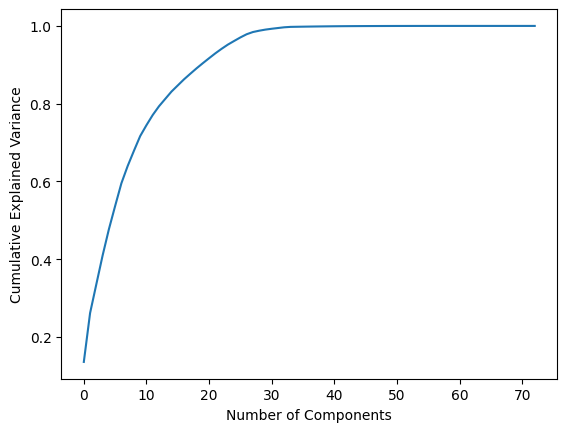

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pca = PCA().fit(X_train_scaled) # 모든 주성분을 사용하여 PCA 적용
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


이 그래프에서, 누적 설명된 분산이 급격히 증가하는 지점을 'elbow point'라고 하며, 이 지점이 적절한 주성분의 수를 나타낼 수 있습니다.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# 가정: X_train_scaled는 이미 스케일링된 데이터입니다.
# X_train_scaled의 차원을 확인합니다.
print("X_train_scaled shape:", X_train_scaled.shape)

# PCA 모델을 초기화하고 훈련 데이터에 적용합니다.
# n_components는 PCA를 적용할 때 몇 개의 주성분을 사용할 것인지를 정합니다.
# 이 값은 X_train_scaled의 특성 수보다 작아야 합니다.
pca = PCA(n_components=24)  # 예시로 20을 사용하나, 실제 사용할 때는 적절한 값을 선택해야 합니다.
X_train_pca = pca.fit_transform(X_train_scaled)

# PCA를 사용하여 차원이 축소된 데이터를 원래의 차원으로 복구합니다.
X_reconstructed = pca.inverse_transform(X_train_pca)

# 복구된 데이터의 차원을 확인합니다.
print("X_reconstructed shape:", X_reconstructed.shape)

# 재구성 오류를 계산합니다.
reconstruction_error = np.mean((X_train_scaled - X_reconstructed) ** 2)
print("Reconstruction Error:", reconstruction_error)


X_train_scaled shape: (14283, 73)
X_reconstructed shape: (14283, 73)
Reconstruction Error: 0.026718253603925105


재구성 오류 0.41 // 일부 정보 손실

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# 예제 데이터 생성 (실제 데이터로 대체하세요)
df = pd.DataFrame(train_cleaned, columns=[f'feature_{i+1}' for i in range(70)])

# PCA 모델 생성 및 학습
pca = PCA(n_components=24)  # 주성분의 수를 데이터 차원과 동일하게 설정
pca.fit(train_cleaned)

# 첫 번째 주성분에 대한 기여도 계산
components = pca.components_[0]  # 첫 번째 주성분
contribution_scores = pd.Series(components, index=train_cleaned.columns)

# 결과 출력
print("첫 번째 주성분에 대한 각 변수의 기여도:")
print(contribution_scores.sort_values(ascending=False))

components = pca.components_[1]  # 첫 번째 주성분
contribution_scores = pd.Series(components, index=train_cleaned.columns)

print("두 번째 주성분에 대한 각 변수의 기여도:")
print(contribution_scores.sort_values(ascending=False))


첫 번째 주성분에 대한 각 변수의 기여도:
total_opp    0.237814
pts_opp      0.237814
total        0.233733
pts          0.233733
drtg         0.226761
               ...   
tov%        -0.058904
trb_opp     -0.087947
trb         -0.089276
drb_opp     -0.091192
drb         -0.094459
Length: 73, dtype: float64
두 번째 주성분에 대한 각 변수의 기여도:
trb%        0.237016
efg%        0.201804
ts%         0.201414
drtg_opp    0.197688
ortg        0.197688
              ...   
drtg       -0.192211
fg%_opp    -0.192801
ts%_opp    -0.196560
efg%_opp   -0.196936
trb%_opp   -0.237015
Length: 73, dtype: float64


Principal Component 1 contributions:
ftr                -0.002651
3par                0.000268
mp                  0.055590
fg                  0.201856
fga                 0.052963
                      ...   
season              0.061030
won                -0.001987
date_gap            0.064729
team_encoded        0.000289
team_opp_encoded    0.005703
Name: 0, Length: 73, dtype: float64


Principal Component 2 contributions:
ftr                -0.000746
3par               -0.000914
mp                  0.000556
fg                  0.168800
fga                -0.014800
                      ...   
season              0.000464
won                 0.167461
date_gap            0.000498
team_encoded        0.033465
team_opp_encoded   -0.034729
Name: 1, Length: 73, dtype: float64


Principal Component 3 contributions:
ftr                -0.000104
3par               -0.003597
mp                  0.397000
fg                  0.053951
fga                 0.257190
                      ...   
s

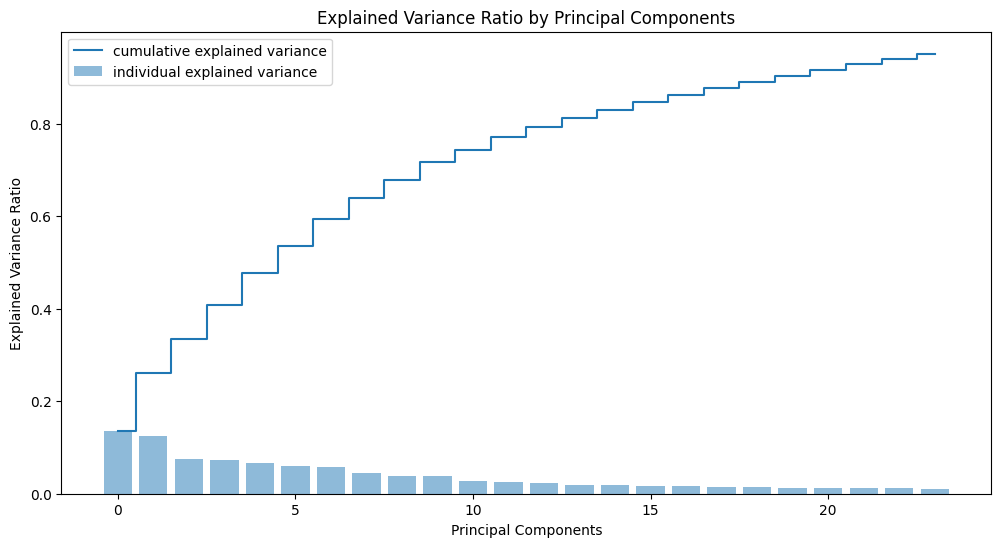

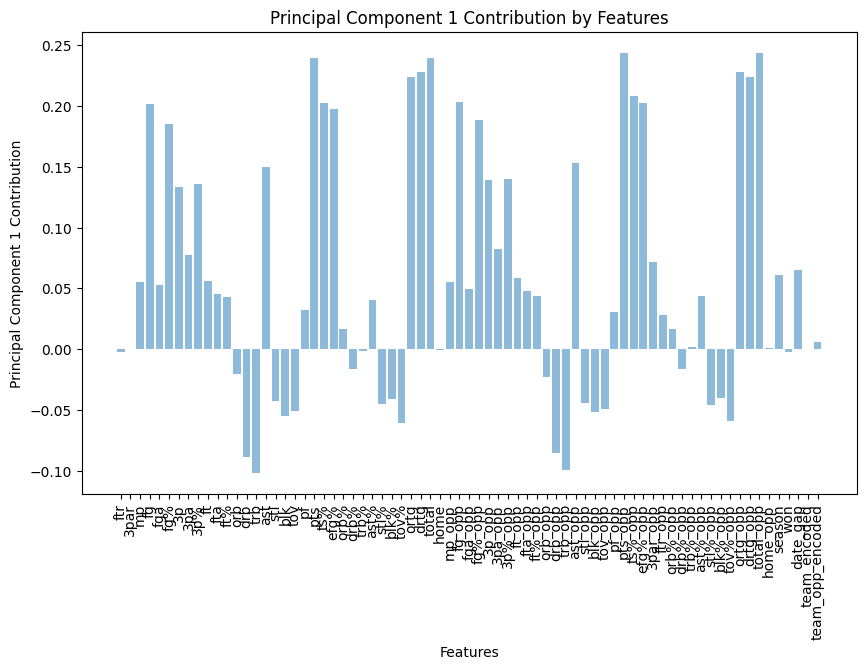

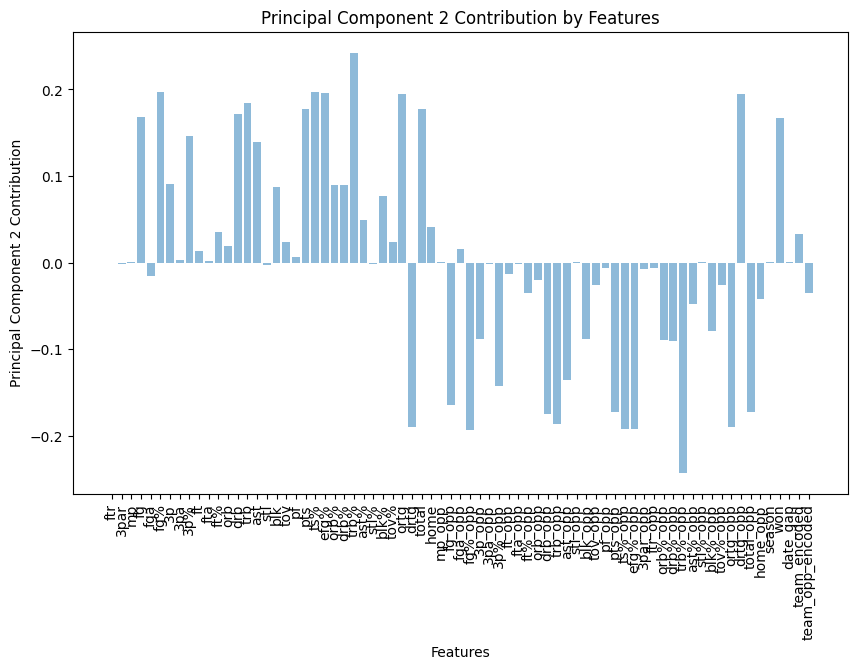

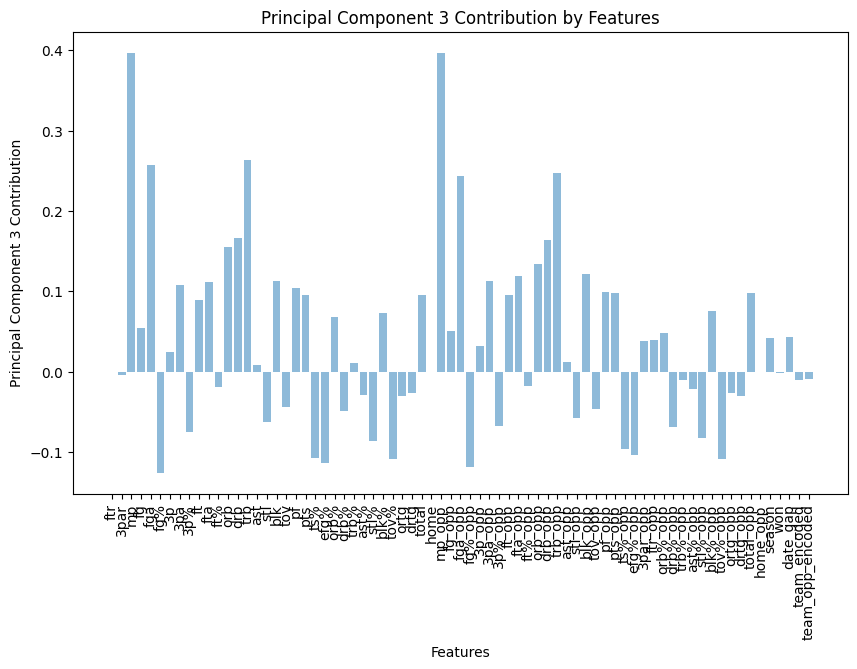

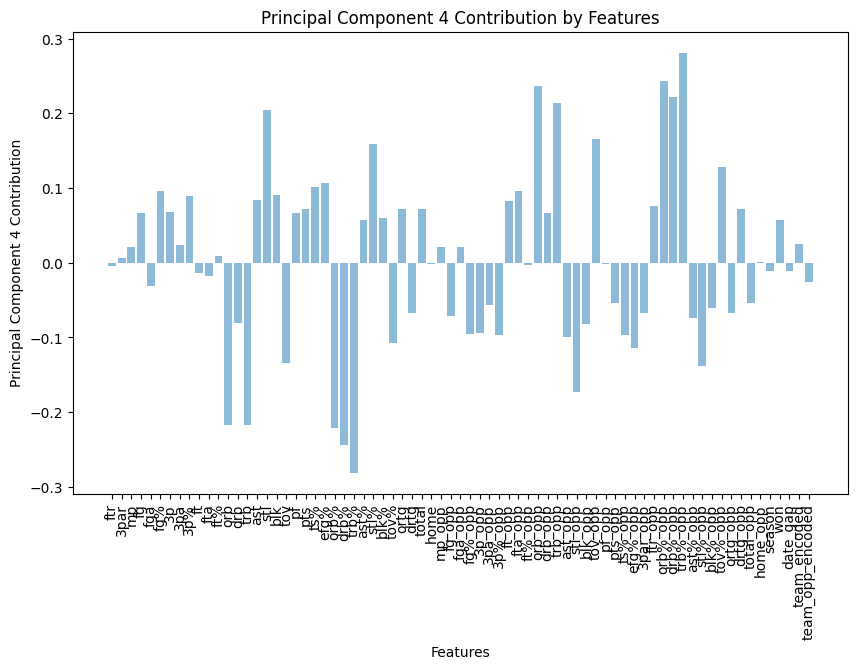

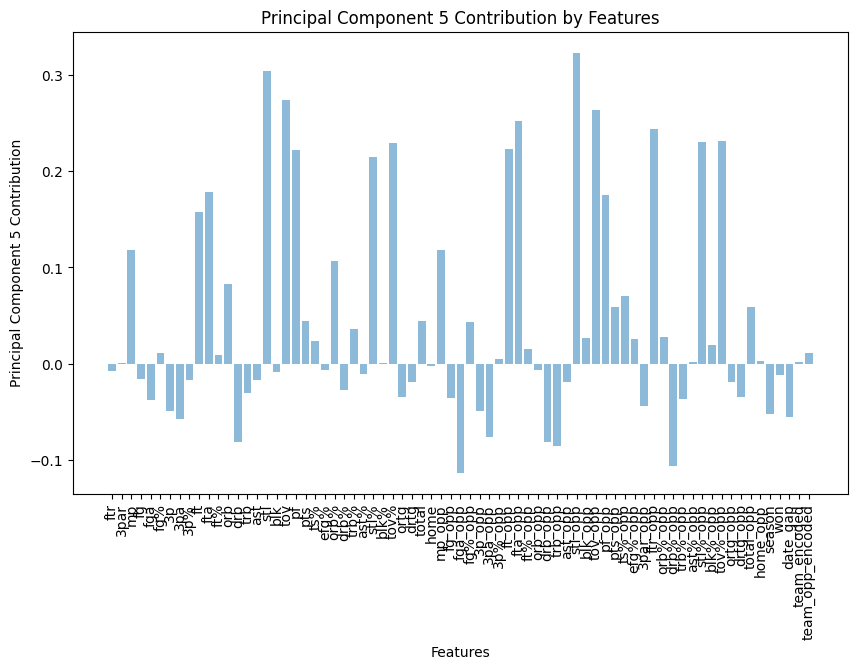

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 주성분 분석 수행 후 pca 객체를 사용하여 주성분에 대한 기여도를 얻습니다.
# 여기서는 X_train_scaled 데이터에 대해 이미 PCA를 수행했다고 가정합니다.
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# 주성분에 대한 원래 특성의 기여도 (components_)를 얻습니다.
components = pca.components_

# 주성분의 수
n_pcs = pca.n_components_

# 데이터프레임의 컬럼 이름
features = train_cleaned.columns

# 각 주성분에 대한 기여도를 데이터프레임으로 변환
pc_df = pd.DataFrame(data=components, columns=features)

# 주성분에 대한 기여도 출력
for i in range(n_pcs):
    print(f"Principal Component {i+1} contributions:")
    print(pc_df.iloc[i])
    print("\n")

# 주성분 기여도 시각화
plt.figure(figsize=(12, 6))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(np.cumsum(pca.explained_variance_ratio_))), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

# 기여도 시각화 (상위 몇 개의 주성분만 예시로 시각화)
n_display_pcs = min(5, n_pcs)  # 상위 5개의 주성분만 시각화

for i in range(n_display_pcs):
    plt.figure(figsize=(10, 6))
    plt.bar(features, pc_df.iloc[i], alpha=0.5)
    plt.xlabel('Features')
    plt.ylabel(f'Principal Component {i+1} Contribution')
    plt.title(f'Principal Component {i+1} Contribution by Features')
    plt.xticks(rotation=90)
    plt.show()


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 주성분 분석 수행 후 pca 객체를 사용하여 주성분에 대한 기여도를 얻습니다.
# 여기서는 X_train_scaled 데이터에 대해 이미 PCA를 수행했다고 가정합니다.
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)

# 주성분에 대한 원래 특성의 기여도 (components_)를 얻습니다.
components = pca.components_

# 주성분의 수
n_pcs = pca.n_components_

# 데이터프레임의 컬럼 이름
features = train_cleaned.columns

# 각 주성분에 대한 기여도를 데이터프레임으로 변환
pc_df = pd.DataFrame(data=components, columns=features)

# 각 주성분에서 기여도가 높은 상위 5개 특성 선택 및 시각화
n_top_features = 5

for i in range(n_pcs):
    component = pc_df.iloc[i]
    sorted_component = component.abs().sort_values(ascending=False)
    top_features = sorted_component.head(n_top_features).index
    top_contributions = component[top_features]

    print(f"주성분 {i+1} top {n_top_features} contributing features:")
    print(top_contributions)
    print("\n")



주성분 1 top 5 contributing features:
pts_opp      0.243785
total_opp    0.243785
total        0.239672
pts          0.239672
ortg_opp     0.228066
Name: 0, dtype: float64


주성분 2 top 5 contributing features:
trb%        0.242461
trb%_opp   -0.242461
fg%         0.197545
ts%         0.196551
efg%        0.196508
Name: 1, dtype: float64


주성분 3 top 5 contributing features:
mp         0.397000
mp_opp     0.397000
trb        0.263554
fga        0.257190
trb_opp    0.247613
Name: 2, dtype: float64


주성분 4 top 5 contributing features:
trb%_opp    0.281183
trb%       -0.281183
orb%_opp    0.243496
drb%       -0.243491
orb_opp     0.236598
Name: 3, dtype: float64


주성분 5 top 5 contributing features:
stl_opp    0.322898
stl        0.303891
tov        0.273342
tov_opp    0.263084
fta_opp    0.251952
Name: 4, dtype: float64


주성분 6 top 5 contributing features:
stl_opp     0.394289
tov%        0.303377
stl%_opp    0.301242
tov         0.294124
fga_opp     0.258153
Name: 5, dtype: float64


주성분 7 top